In [3]:
# You'll have to install NPZ and PyPlot (PyPlot is a lot better than native julia plotting and has same syntax as matplotlib from python)
using LinearAlgebra, NPZ, Random, PyPlot


# Theta is an N-dimensional vector. J is NxN matrix.
function motionalEnergy(θ,J)
    E = 0
    @inbounds for i=1:length(θ)
        @inbounds for j=i:length(θ)
            if i==j
                E += -J[i,j]*cos(θ[i]+θ[j])
            else
                E += -2*J[i,j]*cos(θ[i]+θ[j])
            end
        end
    end
    return E
end

# Theta is again an N-dimensional vector. Tfunc is a function that accepts a step (int or float)
# and returns a temperature (float). Steps is the number of metropolis steps to do. It should be a large number
# scale proportional to N.
@views function Metropolis_mo!(θ, Tfunc, J, steps; stepSize=π/8, stepOffset=0)

    N = length(θ)

    # Do a bunch of Metropolis steps
    @inbounds for step=1:steps

        idx = rand(1:N)
        dθ = randn()*stepSize
        dE = 0
        T = Tfunc(step+stepOffset)
        @inbounds for k=1:N
            if k==idx
                dE -= J[idx,idx]*( cos(2*(θ[idx]+dθ)) - cos(2*θ[idx]) )
            else
                dE -= 2*J[k,idx]*( cos(θ[k]+θ[idx]+dθ) - cos(θ[k]+θ[idx]) )
            end
        end

        # See if the random number is less than the Boltzmann weight
        if rand() < exp(-dE/T)
            θ[idx] += dθ
        end
        
    end
end

# This computes the 2x2 overlap tensor for two replicas.
function olapTensor(θ1,θ2)
   
    N = length(θ1)
    x1 = cos.(θ1)
    y1 = sin.(θ1)
    
    x2 = cos.(θ2)
    y2 = sin.(θ2)
    
    olap = zeros(2,2)
    
    olap[1,1] = dot(x1,x2)/N
    olap[1,2] = dot(x1,y2)/N
    olap[2,1] = dot(y1,x2)/N
    olap[2,2] = dot(y1,y2)/N
    
    return olap
end

# This is the nonlocal interaction in a confocal cavity.
# ϕ>0 models imperfect degeneracy. Sx and Sy are the size of Gaussian atomic distributions
# in units of the fundamental mode waist w00.
function Dnon(x1,x2,y1,y2,ϕ,sx,sy)

    wx2 = 1 + 2*sx^2
    wy2 = 1 + 2*sy^2

    ϕx = log((1+2*sx^2)/(1-2*sx^2))
    ϕy = log((1+2*sy^2)/(1-2*sy^2))

    prefactor = 4/(π * wx2 * wy2 * sqrt((1+exp(-2*(ϕ+ϕx)))*(1+exp(-2*(ϕ+ϕy)))) )

    arg  = -(1-exp(-ϕ)/(wx2*cosh(ϕ+ϕx))) * (x1^2+x2^2)/wx2
    arg += -(1-exp(-ϕ)/(wy2*cosh(ϕ+ϕy))) * (y1^2+y2^2)/wy2

    cosArg = 2*exp(ϕx)*x1*x2 / (wx2^2*cosh(ϕ+ϕx)) + 2*exp(ϕy)*y1*y2 / (wy2^2*cosh(ϕ+ϕy))

    return prefactor * (exp(arg+im*cosArg) + exp(arg-im*cosArg))/2
end

# Makes J matrices using confocal connectivity. 
function confocalJreal(N;ϕ=0,s=0.1,w=2,pos=-1,precision=3)

    if pos==-1
        pos = randn(N,2)*w
    end
    x = pos[:,1]
    y = pos[:,2]

    J = zeros(N,N)
    for i=1:N
        for j=i:N
            J[i,j] = Dnon(x[i],x[j],y[i],y[j],ϕ,s,s)
            J[j,i] = J[i,j]
        end
    end

    return pos,J
end

confocalJreal (generic function with 1 method)

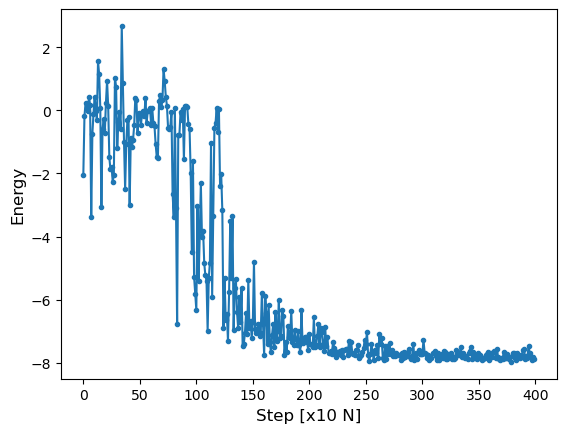

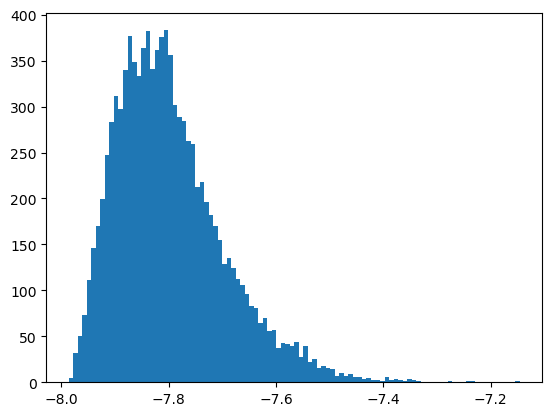

In [21]:
# Example run 
function test()
   
    # Parameters
    N = 8 
    totalSteps = 4000 * N
    
    # Make a symmetric J matrix and normalize by largest eigenvalue
#     J = randn(N,N)
#     J = J+J'
    J = ones(N,N)
    λmax = maximum(eigen(J).values)
    J ./= λmax

    # Make a temperature function
    FinalTemp = 0.05
    T(i) = FinalTemp + 6*exp(-8*i/totalSteps)
    
    # Run metropolis in steps and measure the energy
    stepsize = 10 * N
    numSteps = Int(round(totalSteps/stepsize))
    Es = zeros(numSteps)
    θ = zeros(N)
    for step=1:numSteps
       
        Metropolis_mo!(θ, T, J, stepsize; stepOffset=(step-1)*stepsize)
        
        Es[step] = motionalEnergy(θ,J)
        
    end
    
    numOfSamples = 10000
    Tfinal(i) = FinalTemp
    Esamples = zeros(numOfSamples)
    for step=1:numOfSamples
        Metropolis_mo!(θ, Tfinal, J, stepsize; stepOffset=(step-1)*stepsize)
        Esamples[step] = motionalEnergy(θ,J)
    end
    
    # Plot it
    fig = figure()
    plot(Es,".-")
    xlabel("Step [x10 N]",fontsize=12)
    ylabel("Energy",fontsize=12)
    PyPlot.display_figs()
    
    # Plot histogram
    fig2 = figure()
    plt.hist(Esamples, bins=100)
    PyPlot.display_figs()
end

# Do it
test()